## 1. Configurando a API

> Setup
1. Criar um bot através do BotFather, no aplicativo do Telegram;
2. Pegar o número do **Token** nas configurações do bot;
3. Adicionar o Bot em um grupo e conceder privilégio de admin.

* Carregando as bibliotecas utilizadas

In [ ]:
# Manipulação de dados Sensíveis
from getpass import getpass
# Conexão com a API do Telegram
import requests
# Manipulação dos dados da API
import json

* Variáveis de Ambiente

In [ ]:
# Token do Bot criado
TOKEN = getpass()

# URL para acessar os métodos da API
BASE_URL = f'https://api.telegram.org/bot{TOKEN}'

* Testando a conexão ([Fonte](https://core.telegram.org/bots/api))

In [ ]:
# O método 'getMe' retorna informações sobre o bot criado
response = requests.get(url = f'{BASE_URL}/getMe')

print(
    json.dumps(
        json.loads(response.text),
        indent= 2
    )
)

In [ ]:
# O método 'getUpdates' retorna todas as mensagens captadas pelo bot
response = requests.get(url=f'{BASE_URL}/getUpdates')

print(
    json.dumps(
        json.loads(response.text),
        indent= 2
    )
)

## 2. Data Lake

### 2.1. Ingestão: Raw Data

> Setup
1. Criar um Bucket no `AWS S3` para salvar a ingestão dos dados do Telegram. Nessa etapa trabalharemos com dados no formato `.json`.

> Workflow

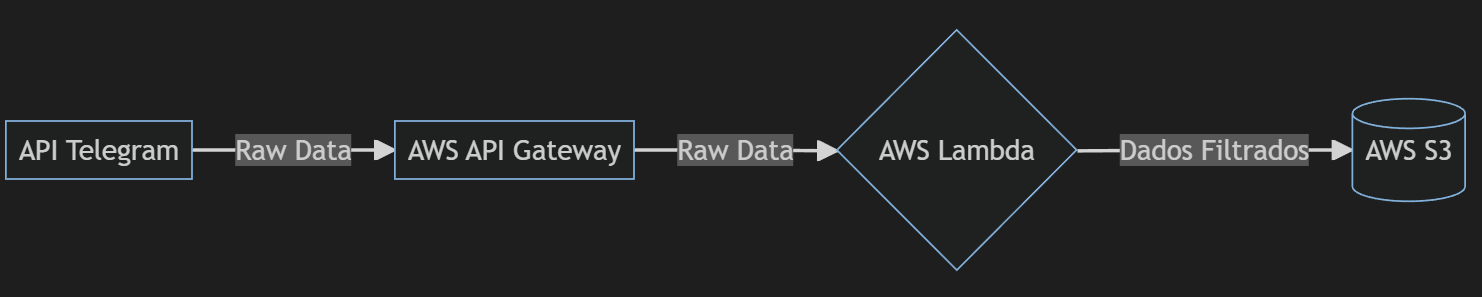

* Os dados serão recolhidos pela API do Telegram e, através de um Webhook, serão redirecionados para o `AWS API Gateway`. 

* Uma função do `AWS Lambda` estará configurada para detectar esses dados recebidos pelo `AWS Gateway`, que realizará a filtragem inicial dos dados de interesse, bem como o particionamento pela data da mensagem. 

* Finalmente, os dados serão salvos na primeira camada do Data Lake, no formato `.json`.
* Salvaremos os dados em seu formato mais inicial para possibilitar um futuro reprocessamento, caso haja necessidade. Neste projeto, teremos que adotar o modelo de processamento em `streaming`, uma vez que as mensagens coletados pela API do Telegram ficam disponíveis por apenas 24h em seus servidores.

> Configurando a função de ingestão no `AWS Lambda`

In [ ]:
import os
import json
import logging
from datetime import datetime, timezone, timedelta

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve, 
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')
  
  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

> **Nota**: É necessário configurar as variáveis de ambiente `TELEGRAM_CHAT_ID` e `BUCKET` nas configurações do Lambda. A primeira serve para conferir se o ID do chat da mensagem que está chegando, corresponde ao chat de interesse (útil caso o mesmo bot esteja conectado em mais de um chat simultaneamente). A segunda variável informa o Bucket do S3 que os dados serão salvos.

> Configurando o `AWS API Gateway`

* A configuração da API REST no `AWS API Gateway` é feita através da própria AWS. Será criado um método `POST` e habilitada a integração com o Lambda (`Lambda Proxy Integration`).

In [ ]:
# Após ser devidamente configurada, iremos salvar a URL gerada pela API Gateway
AWS_GATEWAY_URL = getpass()

>Configurando o `Webhook`

* Aqui utilizaremos a URL fornecida pelo API Gateway para redirecionar os dados da API do Telegram. O método getUpdates deixará de funcionar após a configuração do Webhook.

In [ ]:
# "ok": true significa que a configuração está correta
response = requests.get(url= f'{BASE_URL}setWebhook?url={AWS_GATEWAY_URL}')

* Checando o resultado

In [ ]:
# "ok" : true significa que a configuração está correta
response = requests.get(url= f'{BASE_URL}/getWebhookInfo')

print(
    json.dumps(
        json.loads(response.text),
        indent= 2
    )
)

### 2.2. ETL: Enriched Data

> Setup
1. Criar um Bucket no `AWS S3` para salvar o resultado do ETL. Nessa etapa trabalharemos com dados no formato `.parquet`, mantendo o padrão de particionamento.

> Workflow

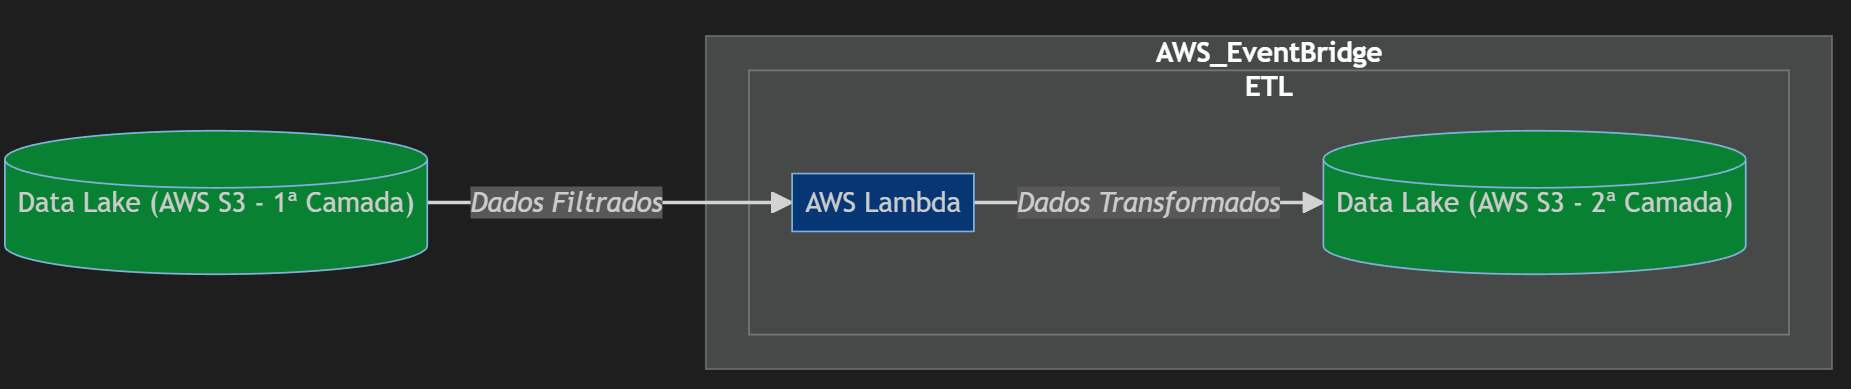

* Nesta etapa, iremos configurar o `AWS EventBridge` para ativar uma Função Lambda todos os dias em um horário pré definido. Essa Função Lambda será responsável pelo ETL dos dados filtrados na primeira etapa do processo, sempre processando os dados do dia *anterior* (d-1).

* Ao final do processo de ETL, os dados serão carregados em uma outra camada do Data Lake, mantendo a condição de particionamento por data, porém agora, sendo salvos no formato `Apache Parquet` e estruturados de forma tabular, graças a utilização do `PyArrow`. Este formato é ideal para a etapa que virá adiante, a etapa de **Data Analytics**.

> Configurando a Função de ETL no `AWS Lambda`

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único 
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  # Bucket S3 com os dados filtrados (1ª Camada do Data Lake)
  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  # Bucket S3 destino onde será salvo o resultado do ETL (2ª Camada do Data Lake)
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  # Configurando o fuso horário pro Brasil
  tzinfo = timezone(offset=timedelta(hours=-3))
  # Pegando a data do dia anterior
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  # Timestamp para nomear os arquivos
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:
      # Lista todos os arquivos que estão na 1ª Camada do Data Lake
      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      # Iterando sobre cada arquivo existente
      for content in response['Contents']:

        key = content['Key']
        # Baixa o arquivo da iteração atual e salva na pasta temporária fornecida pelo Lambda
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        # Abre o arquivo baixado em forma de leitura (lembrando que ainda estamos trabalhando com um .json)
        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:
          
          # Carrega o conteúdo do arquivo
          data = json.load(fp)
          # Coleta apenas o que estava contido na mensagem enviada pelo usuário do Chatbot
          data = data["message"]

        # Aplica a função de data wrangling para transformar os dados
        parsed_data = parse_data(data=data)

        # Insere as informações coletadas e transformadas em uma tabela do PyArrow
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:
          # Concatena a tabela formada na iteração atual com a tabela final
          table = pa.concat_tables([table, iter_table])

        else:
          
          table = iter_table
          iter_table = None
          
      # Ao término da iteração, salva a tabela final em formato parquet    
      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      # Carrega a tabela final na 2ª camada do data lake, particionando por data
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True
  
  # Checa e retorna caso exista algum erro
  except Exception as exc:
      logging.error(msg=exc)
      return False
  
# Função para Data Wrangling
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

> **Obs.** Como o PyArrow não é uma biblioteca vínculada ao Lambda por padrão, é necessário a criação de uma Layer para utilização do `AWSSDKPandas-Python38` (este projeto está sendo desenvolvido na runtime **Python 3.8** )

> Criando um *scheduler* no `AWS EventBridge`

* Aqui configuramos uma "regra" no EventBridge para executar a Função Lambda de ETL em um horário específico do dia. A única configuração necessária é a expressão *cron* correta que reflete o horário desejado, tendo em mente a diferença de **fuso horário**.

## 3. Data Analytics

### 3.1. Setup e Visão Geral

> Workflow

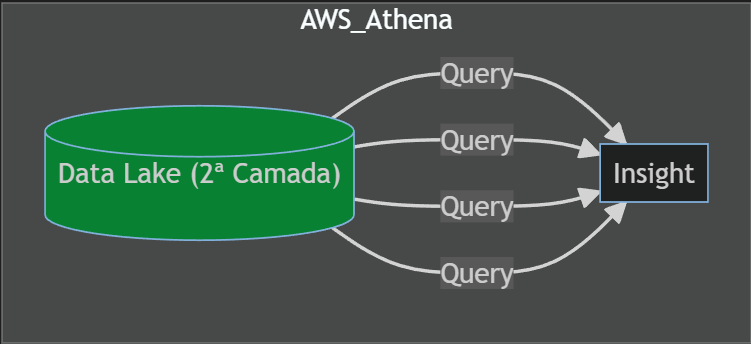

* Criação da Tabela

```sql
CREATE EXTERNAL TABLE chatbot(
  message_id bigint, 
  user_id bigint, 
  user_is_bot boolean, 
  user_first_name string, 
  chat_id bigint, 
  chat_type string, 
  text string, 
  date bigint)
PARTITIONED BY ( 
  context_date date) -- informando que a tabela está particionada
ROW FORMAT SERDE 
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe' 
STORED AS INPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat' 
OUTPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://<Bucket>/' -- localização da 2ª camada do data lake

```

* Carregando os particionamentos

```sql
MSCK REPAIR TABLE chatbot
```

### 3.2. Data Analysis

> Algumas Queries para extrair informação dos dados coletados

- Quantidade de mensagens por dia.

```sql
SELECT 
  context_date, 
  count(1) AS "message_amount" 
FROM "telegram" 
GROUP BY context_date 
ORDER BY context_date DESC
```

- Quantidade de mensagens por usuário por dia.

```sql
SELECT 
  user_id, 
  user_first_name, 
  context_date, 
  count(1) AS "message_amount" 
FROM "telegram" 
GROUP BY 
  user_id, 
  user_first_name, 
  context_date 
ORDER BY context_date DESC
```

- Média do tamanho das mensagens por usuário por dia.

```sql
SELECT 
  user_id, 
  user_first_name, 
  context_date,
  CAST(AVG(length(text)) AS INT) AS "average_message_length" 
FROM "telegram" 
GROUP BY 
  user_id, 
  user_first_name, 
  context_date 
ORDER BY context_date DESC
```

- Quantidade de mensagens por hora por dia da semana por número da semana.

```sql
WITH 
parsed_date_cte AS (
    SELECT 
        *, 
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram" 
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount" 
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday
```